In [1]:
## Retaining the role to access the data
from sagemaker import get_execution_role

role = get_execution_role()
bucket="ucd-ml"

In [2]:
%%time
import pickle, gzip, numpy, urllib.request, json

# Load the dataset
urllib.request.urlretrieve("http://deeplearning.net/data/mnist/mnist.pkl.gz", "mnist.pkl.gz")
with gzip.open("mnist.pkl.gz", "rb") as f:
    train_set, valid_set, test_set = pickle.load(f, encoding="latin1")

CPU times: user 892 ms, sys: 308 ms, total: 1.2 s
Wall time: 1.6 s


In [3]:
## To see what how the data set looks like
train_sample, number  = train_set

In [4]:
## 50.0000 observations in training set and each of them is presented by aflattened array of 784, which is 28 x 28. 
## 28 X 28 array shows pixels that belong to the number
train_sample.shape

(50000, 784)

In [5]:
number.shape

(50000,)

In [6]:
## We have done tuple unpacking to get familiar with data. During modelling, train_set will be used for convenience.
number[0]

5

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt

Text(0.5,1,'This is a 5')

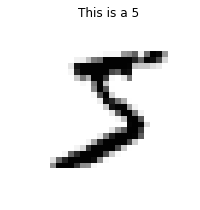

In [8]:
plt.figure(figsize=(3,3))
plt.axis("off")

plt.imshow(train_set[0][0].reshape(28,28), cmap="Greys")
plt.title("This is a {}".format(train_set[1][0]))

Text(0.5,1,'This is a 8')

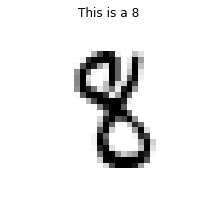

In [9]:
plt.figure(figsize=(3,3))
plt.axis("off")

plt.imshow(train_set[0][49999].reshape(28,28), cmap="Greys")
plt.title("This is a {}".format(train_set[1][49999]))

In [10]:
#Bucket location to save the custom code in tar.gz format.
output_location = "s3://ucd-machine-learning/AWS_Sagemaker_MNIST/code"

#Bucket location where results of model training are saved.
model_location = "s3://ucd-machine-learning/AWS_Sagemaker_MNIST/output"

# IAM execution role that gives SageMaker access to resources in the AWS account.
# It is possible to use the SageMaker Python SDK to get the role from the notebook environment. 

print('training data will be uploaded to: {}'.format(output_location))
print('training artifacts will be uploaded to: {}'.format(model_location))

training data will be uploaded to: s3://ucd-machine-learning/AWS_Sagemaker_MNIST/code
training artifacts will be uploaded to: s3://ucd-machine-learning/AWS_Sagemaker_MNIST/output


In [11]:
!cat "mnist.py"

import logging

import gzip
import mxnet as mx
import numpy as np
import os
import struct


def load_data(path):
    with gzip.open(find_file(path, "labels.gz")) as flbl:
        struct.unpack(">II", flbl.read(8))
        labels = np.fromstring(flbl.read(), dtype=np.int8)
    with gzip.open(find_file(path, "images.gz")) as fimg:
        _, _, rows, cols = struct.unpack(">IIII", fimg.read(16))
        images = np.fromstring(fimg.read(), dtype=np.uint8).reshape(len(labels), rows, cols)
        images = images.reshape(images.shape[0], 1, 28, 28).astype(np.float32) / 255
    return labels, images


def find_file(root_path, file_name):
    for root, dirs, files in os.walk(root_path):
        if file_name in files:
            return os.path.join(root, file_name)


def build_graph():
    data = mx.sym.var('data')
    data = mx.sym.flatten(data=data)
    fc1 = mx.sym.FullyConnected(data=data, num_hidden=128)
    act1 = mx.sym.Activation(data=fc1, act_type="relu")
    fc2 = mx.sym.FullyConnect

### Training MXNet Model

In [12]:
from sagemaker.mxnet import MXNet

mnist_estimator = MXNet(entry_point="mnist.py",
                        role=role,
                        output_path = model_location,
                        code_location = output_location,
                        train_instance_count=1, 
                        train_instance_type="ml.m4.xlarge",
                        hyperparameters={"learning_rate": 0.1})

In [13]:
%%time
import boto3

region = boto3.Session().region_name

train_data_location = "s3://sagemaker-sample-data-{}/mxnet/mnist/train".format(region)
test_data_location = "s3://sagemaker-sample-data-{}/mxnet/mnist/test".format(region)


CPU times: user 8 ms, sys: 0 ns, total: 8 ms
Wall time: 4.75 ms


In [14]:
mnist_estimator.fit({"train": train_data_location, "test": test_data_location})

INFO:sagemaker:Creating training-job with name: sagemaker-mxnet-py2-cpu-2018-03-11-08-01-54-042


.........................................................................
executing startup script (first run)
2018-03-11 08:07:24,389 INFO - root - running container entrypoint
2018-03-11 08:07:24,389 INFO - root - starting train task
2018-03-11 08:07:25,810 INFO - mxnet_container.train - MXNetTrainingEnvironment: {'enable_cloudwatch_metrics': False, 'available_gpus': 0, 'channels': {u'test': {u'TrainingInputMode': u'File', u'RecordWrapperType': u'None', u'S3DistributionType': u'FullyReplicated'}, u'train': {u'TrainingInputMode': u'File', u'RecordWrapperType': u'None', u'S3DistributionType': u'FullyReplicated'}}, '_ps_verbose': 0, 'resource_config': {u'current_host': u'algo-1', u'hosts': [u'algo-1']}, 'user_script_name': u'mnist.py', 'input_config_dir': '/opt/ml/input/config', 'channel_dirs': {u'test': u'/opt/ml/input/data/test', u'train': u'/opt/ml/input/data/train'}, 'code_dir': '/opt/ml/code', 'output_data_dir': '/opt/ml/output/data/', 'output_dir': '/opt/ml/output', 'model_dir': '

2018-03-11 08:08:18,170 INFO - root - Epoch[24] Batch [300]#011Speed: 28761.09 samples/sec#011accuracy=0.998400
2018-03-11 08:08:18,479 INFO - root - Epoch[24] Batch [400]#011Speed: 32395.28 samples/sec#011accuracy=0.998400
2018-03-11 08:08:18,828 INFO - root - Epoch[24] Batch [500]#011Speed: 28660.03 samples/sec#011accuracy=0.998300
2018-03-11 08:08:19,148 INFO - root - Epoch[24] Train-accuracy=0.998990
2018-03-11 08:08:19,148 INFO - root - Epoch[24] Time cost=2.021
2018-03-11 08:08:19,309 INFO - root - Epoch[24] Validation-accuracy=0.975800
===== Job Complete =====


In [15]:
%%time

predictor = mnist_estimator.deploy(initial_instance_count=1, instance_type="ml.m4.xlarge")

INFO:sagemaker:Creating model with name: sagemaker-mxnet-py2-cpu-2018-03-11-08-01-54-042
INFO:sagemaker:Creating endpoint with name sagemaker-mxnet-py2-cpu-2018-03-11-08-01-54-042


---------------------------------------------------------------------------------------------------------------!CPU times: user 456 ms, sys: 40 ms, total: 496 ms
Wall time: 9min 27s


## Model Validation

In [16]:
## Use cursor to draw a number
from IPython.display import HTML
HTML(open("input.html").read())

In [17]:
response = predictor.predict(data)
print('Raw prediction result:')
print(response)

labeled_predictions = list(zip(range(10), response[0]))
print('Labeled predictions: ')
print(labeled_predictions)

labeled_predictions.sort(key=lambda label_and_prob: 1.0 - label_and_prob[1])
print('Most likely answer: {}'.format(labeled_predictions[0]))

Raw prediction result:
[[7.58860363436753e-10, 7.354352646871121e-07, 6.228425775134383e-08, 0.016697576269507408, 1.2559461914918302e-08, 0.9783485531806946, 4.7182388698274735e-06, 1.592211917866848e-10, 0.004938965197652578, 9.419677553523798e-06]]
Labeled predictions: 
[(0, 7.58860363436753e-10), (1, 7.354352646871121e-07), (2, 6.228425775134383e-08), (3, 0.016697576269507408), (4, 1.2559461914918302e-08), (5, 0.9783485531806946), (6, 4.7182388698274735e-06), (7, 1.592211917866848e-10), (8, 0.004938965197652578), (9, 9.419677553523798e-06)]
Most likely answer: (5, 0.9783485531806946)
